### 라이브러리 불러오기

In [1]:
import idx2numpy                                     # 데이터 로드
import matplotlib.pyplot as plt                      # 그래프 표기
import numpy as np                                   
from sklearn.model_selection import train_test_split
import visdom                                        # Visdom
vis = visdom.Visdom()                                # new Visdom server setting

import torch                                         # 파이토치
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

Setting up a new session...


### 하이퍼파라미터 설정

In [2]:
class CFG:
    learning_rate = 0.001
    epochs = 20
    batch_size = 64
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    seed = 42
    shuffle = True
    eps = 1e-7

### Seed 설정

In [3]:
torch.manual_seed(CFG.seed)
if CFG.device == 'cuda':
    torch.cuda.manual_seed_all(CFG.seed)

### 데이터 불러오기

In [4]:
# Data source: http://yann.lecun.com/exdb/mnist/
train_data = idx2numpy.convert_from_file('data/train-images.idx3-ubyte')
train_label = idx2numpy.convert_from_file('data/train-labels.idx1-ubyte')

test_data = idx2numpy.convert_from_file('data/t10k-images.idx3-ubyte')
test_label = idx2numpy.convert_from_file('data/t10k-labels.idx1-ubyte')

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


### 데이터 확인

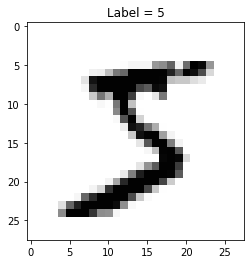

In [5]:
index = 0
data = train_data[index]
label = train_label[index]

plt.title('Label = %s'%(label))
plt.imshow(data, cmap='Greys')
plt.show()

### 원핫 인코딩

In [6]:
train_onehot = np.full((len(train_label), 10), 0)
for i, index in enumerate(train_label):
    train_onehot[i, index] = 1
    
test_onehot = np.full((len(test_label), 10), 0)
for i, index in enumerate(test_label):
    test_onehot[i, index] = 1
    
print(train_onehot.shape)
print(test_onehot.shape)

(60000, 10)
(10000, 10)


### 데이터 로더

In [7]:
class MNIST_Dataset(Dataset):
    def __init__(self, x_data, y_data):
        assert len(x_data) == len(y_data)
        self.x_data = x_data.copy()
        self.y_data = y_data.copy()
                
        self.x_data = self.x_data / 255
        self.x_data = self.x_data.reshape(-1, 1, 28, 28)
        
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.x_data[idx])
        y = torch.FloatTensor(self.y_data[idx])
        return x, y

In [8]:
train_onehot.shape

(60000, 10)

In [9]:
x_train, x_valid, y_train, y_valid = train_test_split(train_data, train_onehot, test_size=0.2, random_state=CFG.seed)
x_test, y_test = test_data, test_onehot

train_dataset = MNIST_Dataset(x_train, y_train)
valid_dataset = MNIST_Dataset(x_valid, y_valid)
test_dataset = MNIST_Dataset(x_test, y_test)

print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

48000
12000
10000


In [10]:
x, y = train_dataset[:]
print(x.shape)
print(y.shape)

torch.Size([48000, 1, 28, 28])
torch.Size([48000, 10])


In [11]:
dataloader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=CFG.shuffle)

In [12]:
for samples in dataloader:
    x_train, y_train = samples
    break

In [13]:
print(x_train.shape)
print(y_train.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 10])


### 모델 만들기

In [14]:
class CNN_MODEL(nn.Module):
    def __init__(self):
        super(CNN_MODEL, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.max_1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_2 = nn.MaxPool2d(2)
        
        self.linear = nn.Linear(in_features=64*7*7, out_features=10, bias=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_2(x)
        
        x = x.view(-1, 64*7*7)
        x = self.linear(x) 
        x = F.softmax(x, dim=1)
        return x

In [15]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
model = CNN_MODEL().to(CFG.device)
model.apply(init_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=CFG.learning_rate)

def logloss(true, pred):
    return torch.mean(-1 * torch.sum(true * torch.log(pred + CFG.eps), axis=1))

### 모델 훈련

In [16]:
for epoch in range(CFG.epochs):
    _train_loss = []
    for samples in dataloader:
        x_train, y_train = samples
        x_train, y_train = x_train.to(CFG.device), y_train.to(CFG.device)
       
        pred = model(x_train)    
        loss = logloss(y_train, pred)
        _train_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss = np.mean(_train_loss)
    
    with torch.no_grad():
        x_valid, y_valid = valid_dataset[:]
        x_valid, y_valid = x_valid.to(CFG.device), y_valid.to(CFG.device)

        pred = model(x_valid)
        loss = logloss(y_valid, pred)
        valid_loss = loss.item()    
    
    if epoch == 0:
        plt = vis.line(
            X=[[epoch, epoch]], 
            Y=[[train_loss, valid_loss]], 
            opts = {
                'xlabel': 'Epoch',
                'ylabel': 'Loss',
                'legend': ['Training', 'Validation'],
                'showlegend': True
            },
        )
    else:
        vis.line(
            X=[[epoch, epoch]], 
            Y=[[train_loss, valid_loss]], 
            win=plt, 
            update="append"
        )

    print('Training: %.6f, Validation: %.6f'%(train_loss, valid_loss))

Training: 0.209470, Validation: 0.074034
Training: 0.061497, Validation: 0.061836
Training: 0.044468, Validation: 0.057407
Training: 0.035232, Validation: 0.043119
Training: 0.027314, Validation: 0.042162
Training: 0.022846, Validation: 0.043081
Training: 0.019142, Validation: 0.043678
Training: 0.015040, Validation: 0.042822
Training: 0.012421, Validation: 0.043053
Training: 0.010754, Validation: 0.049524
Training: 0.008267, Validation: 0.049193
Training: 0.007814, Validation: 0.050953
Training: 0.006937, Validation: 0.054596
Training: 0.006197, Validation: 0.064391
Training: 0.005554, Validation: 0.050557
Training: 0.004257, Validation: 0.056808
Training: 0.003982, Validation: 0.060174
Training: 0.004406, Validation: 0.059289
Training: 0.004893, Validation: 0.054291
Training: 0.001898, Validation: 0.057278


### 모델 테스트

In [17]:
with torch.no_grad():
    x_test, y_test = test_dataset[:]
    x_test = x_test.to(CFG.device)
    y_test = y_test.to(CFG.device)
    
    pred = model(x_test)
    pred = torch.argmax(pred, axis=1).cpu().detach().numpy()
    true = torch.argmax(y_test, axis=1).cpu().detach().numpy()
    accuracy = np.mean(pred == true)

print('Test Accuracy: %.2f %%'%(100*accuracy))

Test Accuracy: 98.97 %
